In [3]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from helper import series_to_supervised
from model.mlp import mlp_layer

2024-01-11 22:18:11.623394: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
# import random

# random.seed(10)
# print(random.random())

In [6]:
data = pd.read_csv("../../data/pollution.csv", index_col=0)
data.fillna(0, inplace=True)
data.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


In [7]:
data.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE',
       'NW', 'SE', 'cv'],
      dtype='object')

### Preprocess

In [8]:
values = data.values

# specify the number of lag hours
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)
print("reframed.shape:", reframed.shape)

reframed.shape: (43717, 924)


In [9]:
# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 0
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (30601, 792) (30601, 12) (6558, 792) (6558, 12) (6558, 792) (6558, 12)


In [10]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (30601, 72, 11) (30601, 12) (6558, 72, 11) (6558, 12) (6558, 72, 11) (6558, 12)


### PM threshold

In [11]:
train_X_pm = train_X[:, 0, feature_idx]
print(train_X_pm.shape)

val_X_pm = val_X[:, 0, feature_idx]
print(val_X_pm.shape)

test_X_pm = test_X[:, 0, feature_idx]
print(test_X_pm.shape)

(30601,)
(6558,)
(6558,)


In [40]:
bin_nums = 20

# Step 1: Calculate the histogram
counts, bin_edges = np.histogram(train_X_pm, bins=bin_nums)

# Step 2: Invert counts to assign lower weights to more frequent bins, avoid division by zero by adding a small number (epsilon)
epsilon = 1e-8
weights = np.sqrt(1.0 / (counts + epsilon))
# weights = 1.0 / (counts + epsilon)

# Step 3: Normalize the weights (optional)
weights /= np.sum(weights) * len(counts)

# Step 4: Assign weights to each sample based on the bin it falls into
sample_weights = np.zeros(train_X_pm.shape[0])

for i, value in enumerate(train_X_pm):
    
    # Find the index of the bin this sample falls into
    bin_index = np.digitize(value, bin_edges) - 1
    bin_index = min(bin_index, bin_nums - 1)
    
    # Assign the corresponding weight
    sample_weights[i] = weights[bin_index]

In [41]:
sample_weights.shape

(30601,)

In [42]:
sample_weights /= np.max(sample_weights)
# sample_weights /= np.sum(sample_weights)
# sample_weights = (sample_weights - sample_weights.min()) / (sample_weights.max()-sample_weights.min()) + 0.1

(array([2.939e+04, 7.760e+02, 3.380e+02, 0.000e+00, 5.400e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 1.700e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 0.000e+00, 1.200e+01,
        0.000e+00, 9.000e+00]),
 array([0.0155118 , 0.06473621, 0.11396062, 0.16318503, 0.21240944,
        0.26163385, 0.31085826, 0.36008267, 0.40930708, 0.45853149,
        0.5077559 , 0.55698031, 0.60620472, 0.65542913, 0.70465354,
        0.75387795, 0.80310236, 0.85232677, 0.90155118, 0.95077559,
        1.        ]),
 <BarContainer object of 20 artists>)

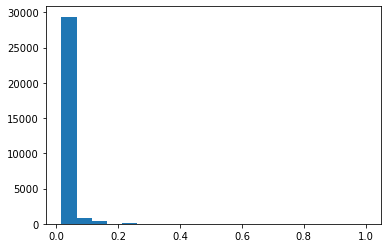

In [43]:
plt.hist(sample_weights, bins=20)

In [44]:
np.save('sample_weights_pm_IPF.npy', sample_weights)

### Model

In [45]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0.0
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 1000
BATCH = 512
opt_num = k
input_shape = train_X.shape[1:]

In [47]:
model = mlp_layer(input_shape=input_shape,
                   mlp_unit1=mlp_unit1,
                   mlp_unit2=mlp_unit2,
                   mlp_unit3=mlp_unit3,
                   mlp_unit4=mlp_unit4,
                   mlp_unit5=mlp_unit5,
                   mlp_unit6=mlp_unit6,
                   mlp_unit7=mlp_unit7,
                   mlp_unit8=mlp_unit8,
                   dropout=dropout,
                   masked_value=-1,
                   opt_num=opt_num
                  )
# model.summary()

In [48]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )

es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models/pm_all_weighted_IPF_95.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True,
                    )


model.fit(train_X, train_y,
          validation_data=(val_X, val_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc],
          sample_weight=sample_weights
         )

Epoch 1/1000
60/60 - 2s - loss: 2.7829e-04 - mae: 0.0699 - val_loss: 0.0157 - val_mae: 0.0869

Epoch 00001: val_mae improved from inf to 0.08687, saving model to ../../saved_models/pm_all_weighted_IPF_95.h5
Epoch 2/1000
60/60 - 1s - loss: 1.5803e-04 - mae: 0.0503 - val_loss: 0.0101 - val_mae: 0.0678

Epoch 00002: val_mae improved from 0.08687 to 0.06784, saving model to ../../saved_models/pm_all_weighted_IPF_95.h5
Epoch 3/1000
60/60 - 1s - loss: 1.3038e-04 - mae: 0.0442 - val_loss: 0.0092 - val_mae: 0.0647

Epoch 00003: val_mae improved from 0.06784 to 0.06471, saving model to ../../saved_models/pm_all_weighted_IPF_95.h5
Epoch 4/1000
60/60 - 1s - loss: 1.2452e-04 - mae: 0.0428 - val_loss: 0.0093 - val_mae: 0.0636

Epoch 00004: val_mae improved from 0.06471 to 0.06364, saving model to ../../saved_models/pm_all_weighted_IPF_95.h5
Epoch 5/1000
60/60 - 1s - loss: 1.2219e-04 - mae: 0.0426 - val_loss: 0.0089 - val_mae: 0.0627

Epoch 00005: val_mae improved from 0.06364 to 0.06266, saving mod


Epoch 00053: val_mae did not improve from 0.06061
Epoch 54/1000
60/60 - 1s - loss: 6.2514e-05 - mae: 0.0346 - val_loss: 0.0115 - val_mae: 0.0706

Epoch 00054: val_mae did not improve from 0.06061
Epoch 55/1000
60/60 - 1s - loss: 6.0679e-05 - mae: 0.0342 - val_loss: 0.0116 - val_mae: 0.0707

Epoch 00055: val_mae did not improve from 0.06061
Epoch 56/1000
60/60 - 1s - loss: 5.9930e-05 - mae: 0.0341 - val_loss: 0.0114 - val_mae: 0.0704

Epoch 00056: val_mae did not improve from 0.06061
Epoch 57/1000
60/60 - 1s - loss: 6.0758e-05 - mae: 0.0343 - val_loss: 0.0111 - val_mae: 0.0691

Epoch 00057: val_mae did not improve from 0.06061
Epoch 58/1000
60/60 - 1s - loss: 6.0070e-05 - mae: 0.0341 - val_loss: 0.0118 - val_mae: 0.0718

Epoch 00058: val_mae did not improve from 0.06061
Epoch 59/1000
60/60 - 1s - loss: 5.9537e-05 - mae: 0.0340 - val_loss: 0.0118 - val_mae: 0.0715

Epoch 00059: val_mae did not improve from 0.06061
Epoch 60/1000
60/60 - 1s - loss: 5.6946e-05 - mae: 0.0334 - val_loss: 0.0

60/60 - 1s - loss: 3.7151e-05 - mae: 0.0279 - val_loss: 0.0151 - val_mae: 0.0831

Epoch 00110: val_mae did not improve from 0.06061
Epoch 111/1000
60/60 - 1s - loss: 3.7426e-05 - mae: 0.0280 - val_loss: 0.0150 - val_mae: 0.0831

Epoch 00111: val_mae did not improve from 0.06061
Epoch 112/1000
60/60 - 1s - loss: 4.0559e-05 - mae: 0.0289 - val_loss: 0.0152 - val_mae: 0.0827

Epoch 00112: val_mae did not improve from 0.06061
Epoch 113/1000
60/60 - 1s - loss: 3.6479e-05 - mae: 0.0276 - val_loss: 0.0152 - val_mae: 0.0833

Epoch 00113: val_mae did not improve from 0.06061
Epoch 114/1000
60/60 - 1s - loss: 3.6551e-05 - mae: 0.0276 - val_loss: 0.0147 - val_mae: 0.0824

Epoch 00114: val_mae did not improve from 0.06061
Epoch 115/1000
60/60 - 1s - loss: 3.4772e-05 - mae: 0.0270 - val_loss: 0.0149 - val_mae: 0.0829

Epoch 00115: val_mae did not improve from 0.06061
Epoch 116/1000
60/60 - 1s - loss: 3.5583e-05 - mae: 0.0273 - val_loss: 0.0155 - val_mae: 0.0851

Epoch 00116: val_mae did not improve

60/60 - 1s - loss: 2.6130e-05 - mae: 0.0235 - val_loss: 0.0171 - val_mae: 0.0909

Epoch 00166: val_mae did not improve from 0.06061
Epoch 167/1000
60/60 - 1s - loss: 2.7117e-05 - mae: 0.0239 - val_loss: 0.0174 - val_mae: 0.0913

Epoch 00167: val_mae did not improve from 0.06061
Epoch 168/1000
60/60 - 1s - loss: 2.6085e-05 - mae: 0.0234 - val_loss: 0.0176 - val_mae: 0.0917

Epoch 00168: val_mae did not improve from 0.06061
Epoch 169/1000
60/60 - 1s - loss: 2.6481e-05 - mae: 0.0236 - val_loss: 0.0169 - val_mae: 0.0910

Epoch 00169: val_mae did not improve from 0.06061
Epoch 170/1000
60/60 - 1s - loss: 2.6317e-05 - mae: 0.0236 - val_loss: 0.0176 - val_mae: 0.0923

Epoch 00170: val_mae did not improve from 0.06061
Epoch 171/1000
60/60 - 1s - loss: 2.5772e-05 - mae: 0.0233 - val_loss: 0.0178 - val_mae: 0.0930

Epoch 00171: val_mae did not improve from 0.06061
Epoch 172/1000
60/60 - 1s - loss: 2.5828e-05 - mae: 0.0233 - val_loss: 0.0182 - val_mae: 0.0932

Epoch 00172: val_mae did not improve